# SLU10 - Metrics for regression: Learning Notebook

In this notebook, you will learn about:
    - Loss functions vs. Evaluation Metrics
    - Mean Squared Error (MSE)
    - Root Mean Squared Error (RMSE)
    - Mean Absolute Error (MAE)
    - Coefficient of Determination (R²)
    - Adjusted R²
    - Scikitlearn metrics
    - Using metrics

## 1 - Loss functions vs. Evaluation metrics

A big part of data science is translating customer business problems into machine learning problems. An important step in this process is defining the **key performance indicators (KPIs)**. These are basically measures of success. To obtain maximum success your model should optimise towards these KPIs. Unfortunately, this is not always possible. 

As you know, the learning process during model training requires a differentiable loss function, and you have no guarantees that the KPI you defined with your customer will be differentiable. This means you need a proxy metric that approximates the true KPI but is differentiable. 

In common literature the KPI is actually called the evaluation metric, and the proxy metric you use to train the model is the loss function. Many times these are actually the same, but you should be aware that they mean different things. So, don't forget:

* **Loss function** is what your model will minimize;
* **Evaluation metric** is what you will use to evaluate how good your model is.

Normally the workflow is that you are given or you collaboratively define an evaluation metric. If this metric is differentiable, then you should most probably use it as your loss function. If it isn't, you should find an adequate proxy loss function.

Next we'll cover several metrics for regression problems that can be used both as evaluation metrics.

## 2 - Metrics for regression
### 2.1 - Mean Squared Error (MSE)

$$MSE = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2$$

where $N$ is the number of observations in your dataset, $y_n$ is the target and $\hat{y}_n$ is the prediction given the observation $x_n$.

In [1]:
mse = lambda y, y_hat: ((y - y_hat)**2).mean()

* Corresponds to converging to the mean of the target distribution
* Loses interpretability due to the squaring. So, if you're predicting a price, the labels have the unit \\$ but the evaluation metric has the unit \\$².
* It is sensible to outliers.

### 2.2 - Root Mean Squared Error (RMSE)

$$RMSE = \sqrt{MSE}$$

In [2]:
rmse = lambda y, y_hat: np.sqrt(mse(y, y_hat))

* Normally prefered to the MSE because the square root recovers some of the interpretability. Continuing the previous example, the evaluation metric now has the unit $.

### 2.3 - Mean Absolute Error (MAE)

$$MAE = \frac{1}{N} \sum_{n=1}^N \left|y_n - \hat{y}_n\right|$$

where $N$ is the number of observations in your dataset, $y_n$ is the target and $\hat{y}_n$ is the prediction given the observation $x_n$.

In [3]:
mae = lambda y, y_hat: np.abs(y - y_hat).mean()

* Corresponds to converging towards the median of the distribution.
* It's more robust to outliers.
* It's more interpretable than the MSE since its values are on the same units as the target.
* The output can be interpreted as the expected error measured in the same units as the target.
* Given that the MAE is not differentiable at 0, most libraries implement slight variations that solve this.

### 2.4 - Coefficient of Determination (R²)

$$\bar{y} = \frac{1}{N} \sum_{n=1}^N y_n$$

$$R² = 1 - \frac{MSE(y, \hat{y})}{MSE(y, \bar{y})} 
= 1 - \frac{\frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2}{\frac{1}{N} \sum_{n=1}^N (y_n - \bar{y})^2}
= 1 - \frac{\sum_{n=1}^N (y_n - \hat{y}_n)^2}{\sum_{n=1}^N (y_n - \bar{y})^2}$$

where $N$ is the number of observations in your dataset, $y_n$ is the target and $\hat{y}_n$ is the prediction given the observation $x_n$.

In [4]:
r2 = lambda y, y_hat: 1 - (mse(y, y_hat) / mse(y, np.mean(y)))

* R² compares how much better your regression model is when compared with a predictor that outputs just the mean of the targets. The higher is R², the more sure you are that the independent variables you used explain how the dependent variable changes. For example, if you got a R² of 0.7, you can say that the set of features you used are able to explain 70% of the target variable.
* Another interpretaiton is that R² measures the linear correlation between the predictions and the target. 
* The R² has an upper bound of 1, depending on your application this may be an advantage. An R² = 0 or below means that your model doesn't explain anything in the target by using the features you have selected.
* Also, when using R², there are something important [caveats](https://en.wikipedia.org/wiki/Coefficient_of_determination#Caveats) to take into account. One of the caveats is that, depending on the model, using more features can inflate the R² when, in fact, those features are really noisy, meaning the model is actually fitting to the noise.

### 2.5 - Adjusted R²

$$R_{adj}^2 = 1 - \frac{N - 1}{N - K - 1} (1 - R^2)$$

where $N$ is the number of observations in the training dataset and K is the number of features your model is using.

In [5]:
adjusted_r2 = lambda y, y_hat, N, K: 1 - ((N - 1) / (N - K - 1)) * (1 - r2(y, y_hat))

* In order to take into account the addition of useless variables, we can use the adjusted R² score

## 3 - Using the metrics

As you learned in previous units, there are many ways of selecting your best estimator, and most of it relies on some way of measuring an in-sample-error (ISE) - computed on data used for training - and an out-of-sample error (OSE) - computed on data not used for training. 

### 3.1 - Hold out method

One of the methods you've seen is the hold-out method, where you can just split your data in a training set, where we will compute the ISE, and a test set, where we will compute the OSE.

Let's start by seeing how to use this method with different metrics. First, let's load some data. 

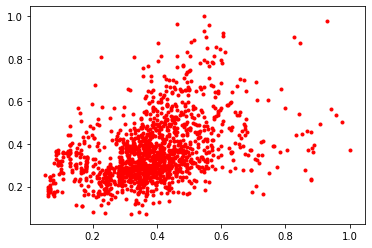

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('data/example_data.csv')
x = df['LotArea'].values
y = df['SalePrice'].values

plt.plot(x, y, 'r.')

Now, remember the sklearn function to get your split for the hold-out method:

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=10)
print("Number of observations:\nTrain: {} | Test: {}".format(x_train.shape[0], x_test.shape[0]))

Number of observations:
Train: 852 | Test: 569


We now want to train some models and get estimates on both the training data and the test data. Let's train three models:
* **Linear Regression**: You have learned about this model in SLU07. It is the closed form solution for optimising towards the RMSE.
* **SGDRegressor:** You have learned about this model in SLU07. It is a iterative solution for linear regression based on SGD. By default it optimises for the RMSE.
* **SGDRegressor_MAE:** This is a slight variation of the SGDRegressor where we change the loss to *epsilon insensitive* and the epsilon to 0. For now you only need to know that this is an approximation so that the SGD converges to the MAE instead of the RMSE.

In [8]:
from sklearn import linear_model

x_train_clf = x_train.reshape(-1, 1)
x_test_clf = x_test.reshape(-1, 1)

clf_1 = linear_model.LinearRegression()
clf_2 = linear_model.SGDRegressor(random_state=10)
clf_3 = linear_model.SGDRegressor(loss='epsilon_insensitive', epsilon=0, random_state=10)

clf_1.fit(x_train_clf, y_train)
clf_2.fit(x_train_clf, y_train)
clf_3.fit(x_train_clf, y_train)

y_hat_train_1 = clf_1.predict(x_train_clf)
y_hat_train_2 = clf_2.predict(x_train_clf)
y_hat_train_3 = clf_3.predict(x_train_clf)


y_hat_test_1 = clf_1.predict(x_test_clf)
y_hat_test_2 = clf_2.predict(x_test_clf)
y_hat_test_3 = clf_3.predict(x_test_clf)

Let's compare the metrics on both sets:

In [9]:
print("Mean Squared Error (MAE)")
print("LinearRegression (Train): {}".format(mae(y_train, y_hat_train_1)))
print("SGDRegressor (Train): {}".format(mae(y_train, y_hat_train_2)))
print("SGDRegressor_MAE (Train): {}".format(mae(y_train, y_hat_train_3)))
print("LinearRegression (Test): {}".format(mae(y_test, y_hat_test_1)))
print("SGDRegressor (Test): {}".format(mae(y_test, y_hat_test_2)))
print("SGDRegressor_MAE (Test): {}".format(mae(y_test, y_hat_test_3)))

print("\n========================\n")

print("Root Mean Squared Error (RMSE)")
print("LinearRegression (Train): {}".format(rmse(y_train, y_hat_train_1)))
print("SGDRegressor (Train): {}".format(rmse(y_train, y_hat_train_2)))
print("SGDRegressor_MAE (Train): {}".format(rmse(y_train, y_hat_train_3)))
print("LinearRegression (Test): {}".format(rmse(y_test, y_hat_test_1)))
print("SGDRegressor (Test): {}".format(rmse(y_test, y_hat_test_2)))
print("SGDRegressor_MAE (Test): {}".format(rmse(y_test, y_hat_test_3)))

print("\n========================\n")

print("R Squared (R2)")
print("LinearRegression (Train): {}".format(r2(y_train, y_hat_train_1)))
print("SGDRegressor (Train): {}".format(r2(y_train, y_hat_train_2)))
print("SGDRegressor_MAE (Train): {}".format(r2(y_train, y_hat_train_3)))
print("LinearRegression (Test): {}".format(r2(y_test, y_hat_test_1)))
print("SGDRegressor (Test): {}".format(r2(y_test, y_hat_test_2)))
print("SGDRegressor_MAE (Test): {}".format(r2(y_test, y_hat_test_3)))

Mean Squared Error (MAE)
LinearRegression (Train): 0.1045869600187045
SGDRegressor (Train): 0.10691756445904843
SGDRegressor_MAE (Train): 0.10201551648216646
LinearRegression (Test): 0.10231247228421318
SGDRegressor (Test): 0.10676318525512477
SGDRegressor_MAE (Test): 0.09976946697182527


Root Mean Squared Error (RMSE)
LinearRegression (Train): 0.1371304197162865
SGDRegressor (Train): 0.14084638029623725
SGDRegressor_MAE (Train): 0.1440540290850338
LinearRegression (Test): 0.13084320786241477
SGDRegressor (Test): 0.13692955251099317
SGDRegressor_MAE (Test): 0.13724366451104925


R Squared (R2)
LinearRegression (Train): 0.1454781963155537
SGDRegressor (Train): 0.09853904994075191
SGDRegressor_MAE (Train): 0.05701158485101809
LinearRegression (Test): 0.19233940791017645
SGDRegressor (Test): 0.11545301906486449
SGDRegressor_MAE (Test): 0.11139011953629918


As you may have expected, the model that obtains best test MAE is the SGDRegressor_MAE. This is in line with what we previously discussed, you should always use the loss functions that best approximates your evaluation metric. In this case the MAE itself is not available as a loss function, but we can approximate it. For now you don't need to know exactly why those parameters approximate the MAE, it's just important that you remember this concept. 

Regarding the RMSE and the R2 the best model is the linear regression.  But let's look at the atual predictions to get a better intuition:

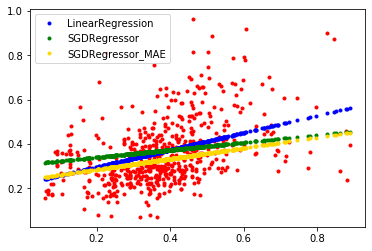

In [10]:
plt.plot(x_test, y_test, 'r.')
plt.plot(x_test, y_hat_test_1, 'r.', color='blue', label='LinearRegression')
plt.plot(x_test, y_hat_test_2, 'r.', color='green', label='SGDRegressor')
plt.plot(x_test, y_hat_test_3, 'r.', color='gold', label='SGDRegressor_MAE')
plt.legend()

It seems that the default SGDRegressor is highly impacted by the outliers on the left, this results in it obtaining a worse MAE than the SGDRegressor_MAE. It's also interesting to note that the linear regression has a stronger slope than the SGDRegressor_MAE, although they have a similar intercept. 

Also, don't forget that the SGD is an iterative based solution that has several parameters, this means that if we tuned the parameters in an extra validation set we may be able to squeeze extra performance. Also, this is just a toy example with one feature, perhaps due to the simplicity of the data it just so happens that linear regression works best.

Finally, to make a consistent analysis, you need to know if our metric should be minimized (like RMSE) or maximized (like R2). If you want to normalize this to make sure your implementation is able to pick a model you can simply impose that your metric should be maximized, for example, and just reverse metrics that don't fit this definition.

For example, we can turn RMSE into negative RMSE and apply the same behavior to other metrics that aim to be minimized. That way, we could write:

In [11]:
mae_mod = lambda y, y_hat: -mae(y, y_hat)
mse_mod = lambda y, y_hat: -mse(y, y_hat)
rmse_mod = lambda y, y_hat: -rmse(y, y_hat)

metrics = {
    'Negative MAE': mae_mod,
    'Negative RMSE': rmse_mod,
    'R2': r2
}

clfs = {
    'LinearRegressor': clf_1,
    'SGDRegressor': clf_2,
    'SGDRegressor_MAE': clf_3
}


for key, clf in clfs.items():
    clf.fit(x_train_clf, y_train)

lst = []
for metric, metric_f in metrics.items():
    
    best = None 
    best_model = None
    lst_lst = []
    print("{}".format(metric))
    for key, clf in clfs.items():
        y_hat_train = clf.predict(x_train_clf)
        y_hat_test = clf.predict(x_test_clf)

        train_score = metric_f(y_train, y_hat_train)
        test_score = metric_f(y_test, y_hat_test)
        print("{} (Train): {}".format(key, train_score))
        print("{} (Test): {}".format(key, test_score))
        if not best or test_score > best:
            best = test_score
            best_model = key
        lst_lst.append([train_score,test_score])
    lst.append(lst_lst)
    print("\nBest model with {}: {}".format(metric, best_model))
        
    print("\n========================\n")
    


Negative MAE
LinearRegressor (Train): -0.1045869600187045
LinearRegressor (Test): -0.10231247228421318
SGDRegressor (Train): -0.10691756445904843
SGDRegressor (Test): -0.10676318525512477
SGDRegressor_MAE (Train): -0.10201551648216646
SGDRegressor_MAE (Test): -0.09976946697182527

Best model with Negative MAE: SGDRegressor_MAE


Negative RMSE
LinearRegressor (Train): -0.1371304197162865
LinearRegressor (Test): -0.13084320786241477
SGDRegressor (Train): -0.14084638029623725
SGDRegressor (Test): -0.13692955251099317
SGDRegressor_MAE (Train): -0.1440540290850338
SGDRegressor_MAE (Test): -0.13724366451104925

Best model with Negative RMSE: LinearRegressor


R2
LinearRegressor (Train): 0.1454781963155537
LinearRegressor (Test): 0.19233940791017645
SGDRegressor (Train): 0.09853904994075191
SGDRegressor (Test): 0.11545301906486449
SGDRegressor_MAE (Train): 0.05701158485101809
SGDRegressor_MAE (Test): 0.11139011953629918

Best model with R2: LinearRegressor




As you see, it is quite usefull for all metrics to have the same logic in terms of performance, this is, how you should interpret if the model is better or not. We will see the same for cross-validation now.

### 3.2 - K-fold cross validation

Another of the methods you've seen is cross validation by using a division in train/test data K times and assessing the scores that come out of it. Let's use the same example and models as before:

In [12]:
df = pd.read_csv('data/example_data.csv')
x = df['LotArea'].values
y = df['SalePrice'].values

x_clf = x.reshape(-1, 1)
y_clf = y.reshape(-1, 1)

clf_1 = linear_model.LinearRegression()
clf_2 = linear_model.SGDRegressor(random_state=10)
clf_3 = linear_model.SGDRegressor(loss='epsilon_insensitive', epsilon=0, random_state=10)

With scikitlearn, you can run the `cross_val_score` with k-fold and output the scores in each fold for both estimators:

In [13]:
from sklearn.model_selection import cross_val_score

clfs = {
    'LinearRegressor': clf_1,
    'SGDRegressor': clf_2,
    'SGDRegressor_MAE': clf_3
}

for key, clf in clfs.items():
    clf.fit(x_train_clf, y_train)

    
K = 5
for key, clf in clfs.items():
    scores = cross_val_score(clf, x_clf, y, cv=K)
    print('Estimator: {}'.format(key))
    print('Score avg. : {}'.format(scores.mean()))

Estimator: LinearRegressor
Score avg. : 0.15316753486109685
Estimator: SGDRegressor
Score avg. : 0.10532130371304502
Estimator: SGDRegressor_MAE
Score avg. : 0.11667100295160308


But what is this score? If the scoring method is not specified, the estimator scorer is used. For our three estimators, in this particular case, this corresponds to the coefficient of determination R2 of the prediction. 

But what if we want to use another metric? Actually, the `cross_val_score` gives us the possibility of doing so, by passing a `scoring` parameter, which can be a string, for example. You can check [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) all of the possibilities, but for this SLU the most important one are:

* `neg_mean_absolute_error`	 
* `neg_mean_squared_error`	 
* `r2`

In this case, the metrics follow the rule of "higher is better", thus the negative MAE and MSE options. 


In [14]:
from sklearn.model_selection import cross_val_score

clfs = {
    'LinearRegressor': clf_1,
    'SGDRegressor': clf_2,
    'SGDRegressor_MAE': clf_3
}

for key, clf in clfs.items():
    clf.fit(x_train_clf, y_train)

    
K = 5
for key, clf in clfs.items():
    scores = cross_val_score(clf, x_clf, y, cv=K, scoring="neg_mean_absolute_error")
    print('Estimator: {}'.format(key))
    print('Negative MAE avg. : {}'.format(scores.mean()))

Estimator: LinearRegressor
Negative MAE avg. : -0.10347445378375131
Estimator: SGDRegressor
Negative MAE avg. : -0.10599255477662213
Estimator: SGDRegressor_MAE
Negative MAE avg. : -0.10095477222325781


There are also other ways of passing on metrics do these functions, and this is not the only function to perform these comparisons. You can explore the model selection to learn more about it. But for now, move forward to the exercises and the next SLUs.

![goodbye](assets/goodbye.gif)

## 4 - For the more curious

This notebook is not an exhaustive exploration of this topic. Here is some curated material if you want to learn more:
* [Coursera - Regression metrics review I](https://www.coursera.org/lecture/competitive-data-science/regression-metrics-review-i-UWhYf) and [II](https://www.coursera.org/lecture/competitive-data-science/regression-metrics-review-ii-qhRmV)
* [Sklearn - Regression metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)
* [H2O.ai - Regression metrics’ guide](https://www.h2o.ai/blog/regression-metrics-guide/)